## Extract TRILEGAL simulated catalog for a BDBS field and analyze results

In [67]:
from dl import authClient as ac, queryClient as qc
from dl.helpers.utils import convert
from getpass import getpass

In [68]:
## automatically reload any modules read below that might have changed (e.g. plots)
%reload_ext autoreload
%autoreload 2
# importing plotting and locus tools: 
import LocusTools as lt
import BayesTools as bt
import PlotTools as pt
import MakePriors as mp

In [69]:
%matplotlib inline
import sys
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy import interpolate 
from scipy.interpolate import griddata
from scipy.stats import gaussian_kde

In [70]:
# this is for BDBS patch #1 (BDBS data file: field_044.fit)
query = """
SELECT ra, dec, rmag, m_h, av, mu0
FROM lsst_sim.simdr2
WHERE 269 < ra and ra < 271
AND -36 < dec and dec < -34
"""
outputDir = 'priorsDir/BDBS/BDBSpatch1'

# this is for BDBS patch #2 (BDBS data file: l0bm8.fit)
query = """
SELECT ra, dec, rmag, m_h, av, mu0
FROM lsst_sim.simdr2
WHERE 273.5 < ra and ra < 275.5
AND -34 < dec and dec < -32
"""
outputDir = 'priorsDir/BDBS/BDBSpatch2'

In [71]:
# this is for BDBS patch #1 (BDBS data file: field_044.fit)
queryBDBSpatch1 = mp.makeQueryString(269.0, 271.0, -36.0, -34.0)
print(queryBDBSpatch1)
BDBSpatch1 = mp.retrievePatch(queryBDBSpatch1)
print('retrieved', len(BDBSpatch1), 'entries')


    SELECT ra, dec, gall, galb, gc, logage, mass, label, logg, m_h, av, mu0, umag, gmag, rmag, imag, zmag, ymag
    FROM lsst_sim.simdr2
    WHERE 269.0 < ra and ra < 271.0 AND -36.0 < dec and dec < -34.0 AND umag < 99.99 

querying...
converting...
retrieved patch with 23448617  entries
retrieved 23448617 entries


In [72]:
goodu = BDBSpatch1[BDBSpatch1['umag']<21]
print(len(goodu))

279163


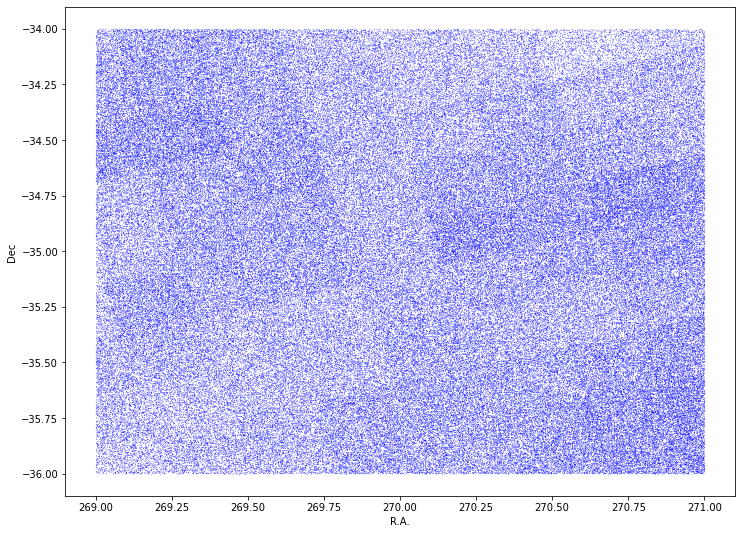

In [73]:
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.set_xlabel('R.A.')
ax.set_ylabel('Dec')
ax.scatter(goodu['ra'], goodu['dec'], s=0.01, c='blue') 

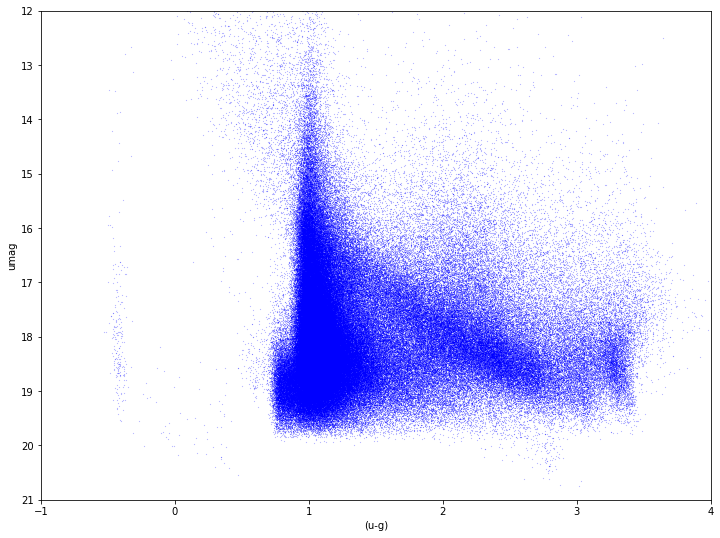

In [74]:
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.set_xlim(-1,4)
ax.set_ylim(21,12) 
ax.set_xlabel('(u-g)')
ax.set_ylabel('umag')
ax.scatter(goodu['ug'], goodu['u'], s=0.01, c='blue') 

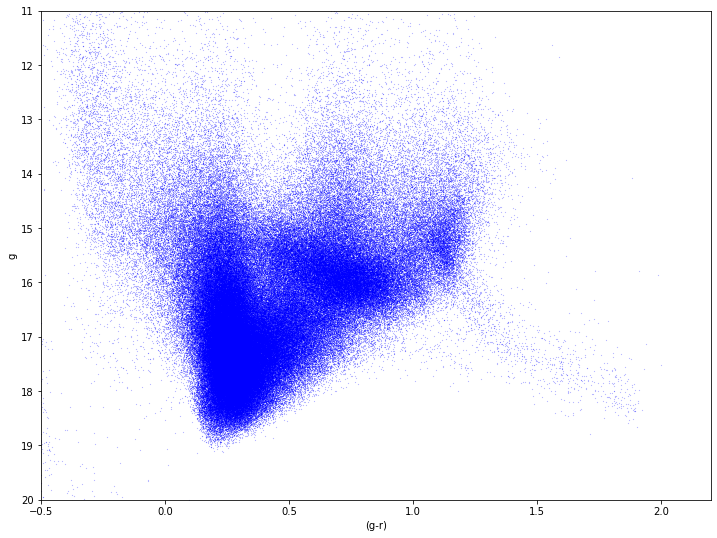

In [75]:
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.set_xlim(-0.5,2.2)
ax.set_ylim(20,11) 

ax.set_xlabel('(g-r)')
ax.set_ylabel('g')
ax.scatter(goodu['gr'], goodu['g'], s=0.01, c='blue') 

In [76]:
oku = goodu[goodu['umag']<20]   # BDBS: 114,184  TRILEGAL: 120,799  
len(oku)

120799

In [77]:
SDSSlocus = lt.LSSTsimsLocus(fixForStripe82=True, datafile='MSandRGBcolors_v1.3.txt')
## selecting a few SDSSlocus tracks at fixed metallicity
FeH0 =  0.0
FeH1 = -1.0
FeH2 = -2.0
SDSSlocus0 = SDSSlocus[(SDSSlocus['FeH']>FeH0-0.01)&(SDSSlocus['FeH']<FeH0+0.01)]
SDSSlocus1 = SDSSlocus[(SDSSlocus['FeH']>FeH1-0.01)&(SDSSlocus['FeH']<FeH1+0.01)]
SDSSlocus2 = SDSSlocus[(SDSSlocus['FeH']>FeH2-0.01)&(SDSSlocus['FeH']<FeH2+0.01)]

Fixing input Mr-FeH-colors grid to agree with the SDSS v4.2 catalog


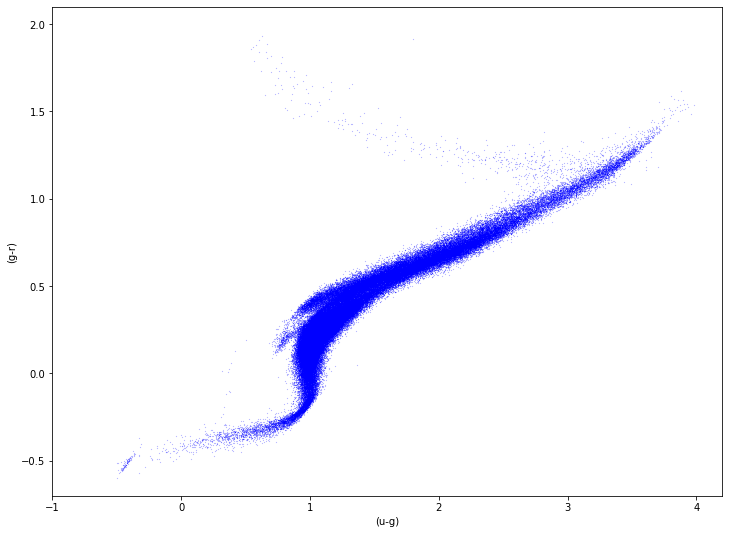

In [79]:
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.set_xlim(-1,4.2)
ax.set_ylim(-0.7,2.1) 
ax.set_xlabel('(u-g)')
ax.set_ylabel('(g-r)')
ax.scatter(oku['ug'], oku['gr'], s=0.01, c='blue') 

In [80]:
okug = oku[oku['gmag']<21]    #  99747
okugB = okug[okug['gmag']<20]    #  99344
okugBB = okugB[okugB['umag']<19]  # 33328
print(len(okug), len(okugB), len(okugBB))

120799 120798 52001


In [81]:
df = okugB
okugB1 = df[df['gc']==1]
okugB2 = df[df['gc']==2]
okugB3 = df[df['gc']==3]
okugB4 = df[df['gc']==4]
print(len(okugB1), len(okugB2), len(okugB3), len(okugB4))

83623 3897 7510 25768


In [82]:
# is bulge with u-g>2.8 high-FeH giants?
gg = okugB1[okugB1['ug']>2.8]

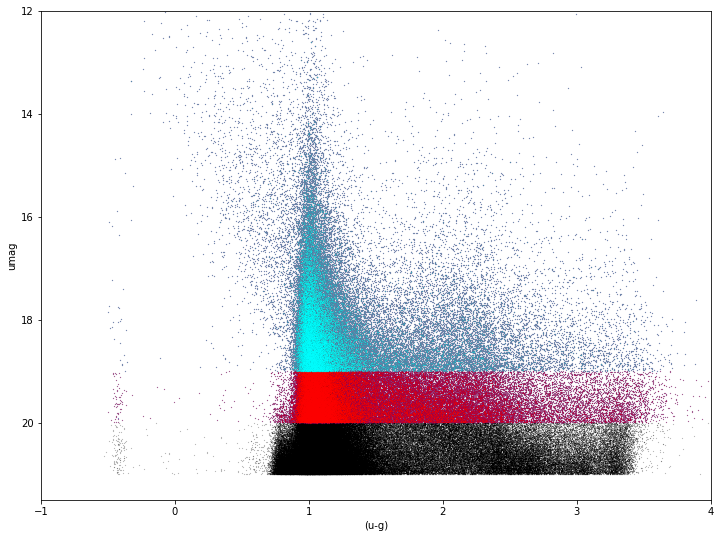

In [83]:
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.set_xlim(-1,4)
ax.set_ylim(21.5,12) 
ax.set_xlabel('(u-g)')
ax.set_ylabel('umag')
ax.scatter(goodu['ug'], goodu['umag'], s=0.01, c='black') 
ax.scatter(oku['ug'], oku['umag'], s=0.01, c='blue')
ax.scatter(okugB['ug'], okugB['umag'], s=0.01, c='red')
ax.scatter(okugBB['ug'], okugBB['umag'], s=0.01, c='cyan')

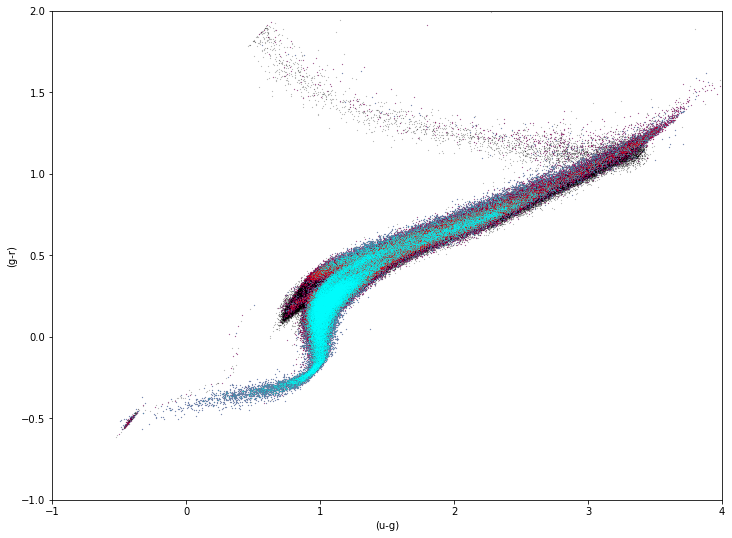

In [84]:
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.set_xlim(-1,4)
ax.set_ylim(-1,2.0) 
ax.set_xlabel('(u-g)')
ax.set_ylabel('(g-r)')
ax.scatter(goodu['ug'], goodu['gr'], s=0.01, c='black')   # good u flags, no u mag cuty
ax.scatter(okug['ug'], okug['gr'], s=0.01, c='blue') 
ax.scatter(okugB['ug'], okugB['gr'], s=0.01, c='red') 
ax.scatter(okugBB['ug'], okugBB['gr'], s=0.01, c='cyan') 

In [85]:
flag = (okug['ug']<2.5)&(okug['gr']>1.2)
okugT = okug[flag]
df = okugT
T1 = df[df['gc']==1]
T2 = df[df['gc']==2]
T3 = df[df['gc']==3]
T4 = df[df['gc']==4]
print(len(okug), len(okugT), len(T1), len(T2), len(T3), len(T4))

120799 190 59 0 0 131


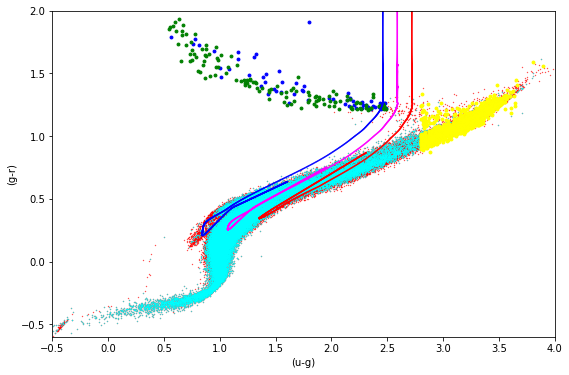

In [88]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_xlim(-0.5,4)
ax.set_ylim(-0.6,2.0) 
ax.set_xlabel('(u-g)')
ax.set_ylabel('(g-r)')
#ax.scatter(okug['ug'], okug['gr'], s=0.1, c='blue')      # good u & g flags & u<20
ax.scatter(okugB['ug'], okugB['gr'], s=0.1, c='red')     # u<20 & g<20
ax.scatter(okugBB['ug'], okugBB['gr'], s=0.1, c='cyan')  # u<19 & g<20
ax.scatter(gg['ug'], gg['gr'], s=8.3, c='yellow')     
ax.scatter(T1['ug'], T1['gr'], s=8.3, c='blue')     
ax.scatter(T4['ug'], T4['gr'], s=8.3, c='green')     

ax.scatter(SDSSlocus0['ug']+0.06, SDSSlocus0['gr'], s=0.3, ls='--', c='red')
ax.scatter(SDSSlocus1['ug']+0.06, SDSSlocus1['gr'], s=0.3, ls='--', c='magenta')
ax.scatter(SDSSlocus2['ug']+0.06, SDSSlocus2['gr'], s=0.3, ls='--', c='blue')

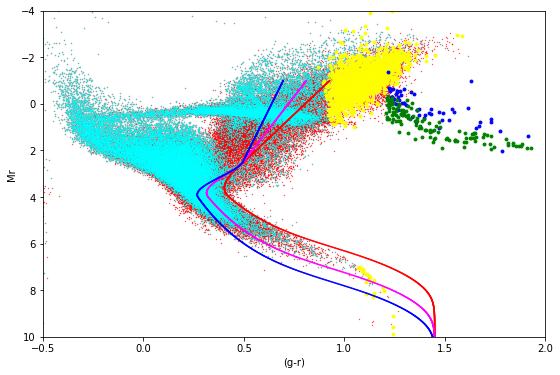

In [89]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_xlim(-0.5,2.0)
ax.set_ylim(10,-4.0) 
ax.set_xlabel('(g-r)')
ax.set_ylabel('Mr')
#ax.scatter(okug['ug'], okug['gr'], s=0.1, c='blue')      # good u & g flags & u<20
ax.scatter(okugB['gr'], okugB['Mr'], s=0.1, c='red')     # u<20 & g<20
ax.scatter(okugBB['gr'], okugBB['Mr'], s=0.1, c='cyan')  # u<19 & g<20

ax.scatter(gg['gr'], gg['Mr'], s=8.3, c='yellow')     
ax.scatter(T1['gr'], T1['Mr'], s=8.3, c='blue')     
ax.scatter(T4['gr'], T4['Mr'], s=8.3, c='green')     

ax.scatter(SDSSlocus0['gr']+0.06, SDSSlocus0['Mr'], s=0.3, ls='--', c='red')
ax.scatter(SDSSlocus1['gr']+0.06, SDSSlocus1['Mr'], s=0.3, ls='--', c='magenta')
ax.scatter(SDSSlocus2['gr']+0.06, SDSSlocus2['Mr'], s=0.3, ls='--', c='blue')

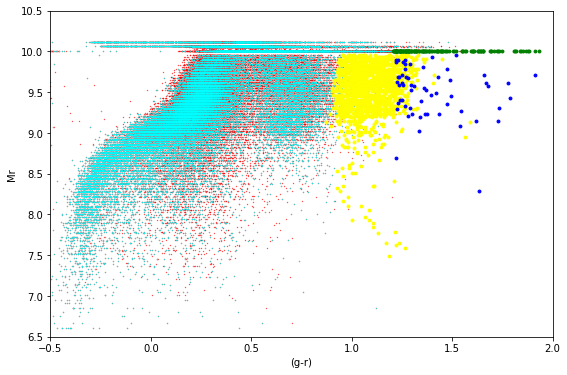

In [90]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_xlim(-0.5, 2.0)
ax.set_ylim(6.5,10.5) 
ax.set_xlabel('(g-r)')
ax.set_ylabel('Mr')
#ax.scatter(okug['ug'], okug['gr'], s=0.1, c='blue')      # good u & g flags & u<20
ax.scatter(okugB['gr'], okugB['logage'], s=0.1, c='red')     # u<20 & g<20
ax.scatter(okugBB['gr'], okugBB['logage'], s=0.1, c='cyan')  # u<19 & g<20

ax.scatter(gg['gr'], gg['logage'], s=8.3, c='yellow')     
ax.scatter(T1['gr'], T1['logage'], s=8.3, c='blue')     
ax.scatter(T4['gr'], T4['logage'], s=8.3, c='green')     
 

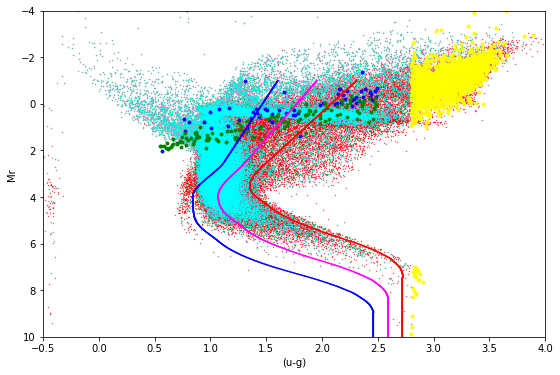

In [91]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_xlim(-0.5,4)
ax.set_ylim(10,-4.0) 
ax.set_xlabel('(u-g)')
ax.set_ylabel('Mr')
#ax.scatter(okug['ug'], okug['gr'], s=0.1, c='blue')      # good u & g flags & u<20
ax.scatter(okugB['ug'], okugB['Mr'], s=0.1, c='red')     # u<20 & g<20
ax.scatter(okugBB['ug'], okugBB['Mr'], s=0.1, c='cyan')  # u<19 & g<20

ax.scatter(gg['ug'], gg['Mr'], s=8.3, c='yellow')     
ax.scatter(T1['ug'], T1['Mr'], s=8.3, c='blue')     
ax.scatter(T4['ug'], T4['Mr'], s=8.3, c='green')     


ax.scatter(SDSSlocus0['ug']+0.06, SDSSlocus0['Mr'], s=0.3, ls='--', c='red')
ax.scatter(SDSSlocus1['ug']+0.06, SDSSlocus1['Mr'], s=0.3, ls='--', c='magenta')
ax.scatter(SDSSlocus2['ug']+0.06, SDSSlocus2['Mr'], s=0.3, ls='--', c='blue')

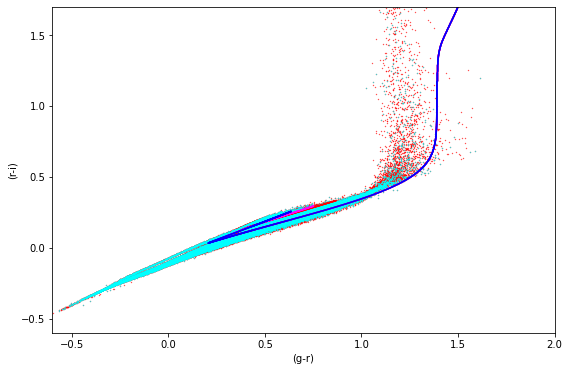

In [92]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_xlim(-0.6,2)
ax.set_ylim(-0.6,1.7) 
ax.set_xlabel('(g-r)')
ax.set_ylabel('(r-i)')
#ax.scatter(okug['gr'], okug['ri'], s=0.1, c='blue')      # good u & g flags & u<20
ax.scatter(okugB['gr'], okugB['ri'], s=0.1, c='red')     # u<20 & g<20
ax.scatter(okugBB['gr'], okugBB['ri'], s=0.1, c='cyan')  # u<19 & g<20

ax.scatter(SDSSlocus0['gr'], SDSSlocus0['ri']-0.028, s=0.3, ls='--', c='red')
ax.scatter(SDSSlocus1['gr'], SDSSlocus1['ri']-0.028, s=0.3, ls='--', c='magenta')
ax.scatter(SDSSlocus2['gr'], SDSSlocus2['ri']-0.028, s=0.3, ls='--', c='blue')

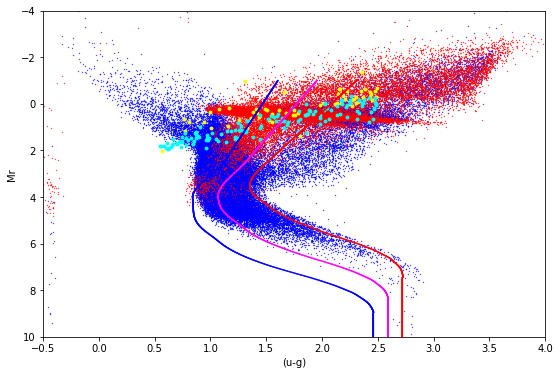

In [93]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_xlim(-0.5,4)
ax.set_ylim(10,-4.0) 
ax.set_xlabel('(u-g)')
ax.set_ylabel('Mr')
ax.scatter(okugB1['ug'], okugB1['Mr'], s=0.1, c='blue')    
#ax.scatter(okugB2['ug'], okugB2['Mr'], s=0.1, c='cyan')    
#ax.scatter(okugB3['ug'], okugB3['Mr'], s=0.1, c='green')     
ax.scatter(okugB4['ug'], okugB4['Mr'], s=0.1, c='red')     
ax.scatter(T1['ug'], T1['Mr'], s=8.3, c='yellow')     
ax.scatter(T4['ug'], T4['Mr'], s=8.3, c='cyan')     

ax.scatter(SDSSlocus0['ug']+0.06, SDSSlocus0['Mr'], s=0.3, ls='--', c='red')
ax.scatter(SDSSlocus1['ug']+0.06, SDSSlocus1['Mr'], s=0.3, ls='--', c='magenta')
ax.scatter(SDSSlocus2['ug']+0.06, SDSSlocus2['Mr'], s=0.3, ls='--', c='blue')

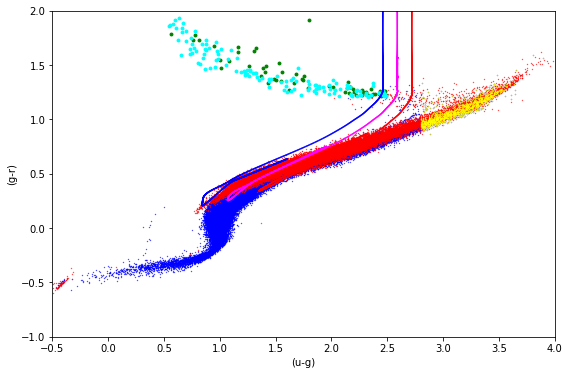

In [94]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_xlim(-0.5,4)
ax.set_ylim(-1,2.0) 
ax.set_xlabel('(u-g)')
ax.set_ylabel('(g-r)')
ax.scatter(okugB1['ug'], okugB1['gr'], s=0.1, c='blue')    
#ax.scatter(okugB2['ug'], okugB2['gr'], s=0.1, c='cyan')    
#ax.scatter(okugB3['ug'], okugB3['gr'], s=0.1, c='green')     
ax.scatter(okugB4['ug'], okugB4['gr'], s=0.1, c='red')     
ax.scatter(gg['ug'], gg['gr'], s=0.1, c='yellow')    
ax.scatter(T1['ug'], T1['gr'], s=8.3, c='green')     
ax.scatter(T4['ug'], T4['gr'], s=8.3, c='cyan')     

ax.scatter(SDSSlocus0['ug']+0.06, SDSSlocus0['gr'], s=0.3, ls='--', c='red')
ax.scatter(SDSSlocus1['ug']+0.06, SDSSlocus1['gr'], s=0.3, ls='--', c='magenta')
ax.scatter(SDSSlocus2['ug']+0.06, SDSSlocus2['gr'], s=0.3, ls='--', c='blue')

In [95]:
# is bulge with u-g>2.8 high-FeH giants?
# gg = okugB1[okugB1['ug']>2.8]

In [96]:
# q = 'FeH'  #  -1.48 -0.19 0.68
q = 'Mr'   #  -3.44 -1.12 1.52  
df=gg
print(len(df), np.min(df[q]), np.median(df[q]), np.max(df[q]))

1549 -4.710467741935484 -0.9950967741935486 9.859596774193548


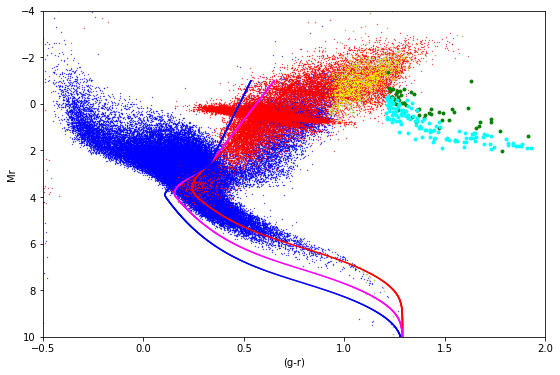

In [97]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_xlim(-0.5,2)
ax.set_ylim(10,-4.0) 
ax.set_xlabel('(g-r)')
ax.set_ylabel('Mr')
ax.scatter(okugB1['gr'], okugB1['Mr'], s=0.1, c='blue')    
#ax.scatter(okugB2['gr'], okugB2['Mr'], s=0.1, c='cyan')    
#ax.scatter(okugB3['gr'], okugB3['Mr'], s=0.1, c='green')     
ax.scatter(okugB4['gr'], okugB4['Mr'], s=0.1, c='red')     
ax.scatter(gg['gr'], gg['Mr'], s=0.1, c='yellow')    
ax.scatter(T1['gr'], T1['Mr'], s=8.3, c='green')     
ax.scatter(T4['gr'], T4['Mr'], s=8.3, c='cyan')     

ax.scatter(SDSSlocus0['gr']-0.1, SDSSlocus0['Mr'], s=0.3, ls='--', c='red')
ax.scatter(SDSSlocus1['gr']-0.1, SDSSlocus1['Mr'], s=0.3, ls='--', c='magenta')
ax.scatter(SDSSlocus2['gr']-0.1, SDSSlocus2['Mr'], s=0.3, ls='--', c='blue')

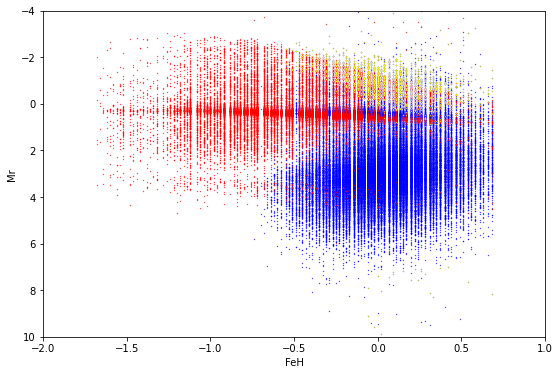

In [98]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_xlim(-2.0,1.0)
ax.set_ylim(10,-4.0) 
ax.set_xlabel('FeH')
ax.set_ylabel('Mr')
ax.scatter(okugB1['FeH'], okugB1['Mr'], s=0.1, c='blue')    
#ax.scatter(okugB2['gr'], okugB2['Mr'], s=0.1, c='cyan')    
#ax.scatter(okugB3['gr'], okugB3['Mr'], s=0.1, c='green')     
ax.scatter(okugB4['FeH'], okugB4['Mr'], s=0.1, c='red')     
ax.scatter(gg['FeH'], gg['Mr'], s=0.1, c='yellow')     


In [99]:
Mflag = (okug['Mr']>0.2)&(okug['Mr']<0.7)
Gh = okug[(okug['FeH']<-1.0)&Mflag]
Gd = okug[(okug['FeH']>-1.0)&Mflag]
len(Gd), len(Gh)

(20255, 3113)

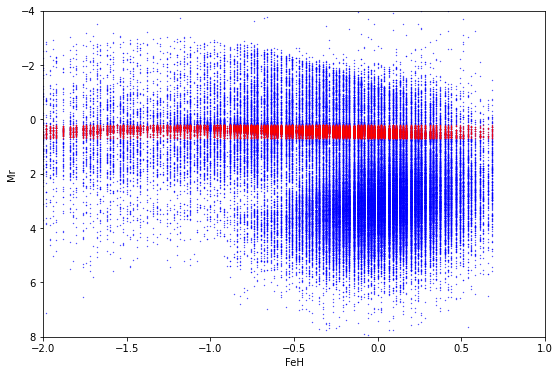

In [100]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_xlim(-2.0,1.0)
ax.set_ylim(8,-4) 
ax.set_xlabel('FeH')
ax.set_ylabel('Mr')
ax.scatter(okug['FeH'], okug['Mr'], s=0.1, c='blue')    
ax.scatter(Gd['FeH'], Gd['Mr'], s=0.1, c='red') 
ax.scatter(Gh['FeH'], Gh['Mr'], s=0.1, c='red')  

In [101]:
df = Gd
dT1 = df[df['gc']==1]
dT2 = df[df['gc']==2]
dT3 = df[df['gc']==3]
dT4 = df[df['gc']==4]
print(len(Gd), len(dT1), len(dT2), len(dT3), len(dT4))

20255 6540 1303 317 12095


In [102]:
df = Gh
T1 = df[df['gc']==1]
T2 = df[df['gc']==2]
T3 = df[df['gc']==3]
T4 = df[df['gc']==4]
print(len(Gh), len(T1), len(T2), len(T3), len(T4))

3113 0 0 2244 869


In [103]:
df = T1
T0 = df[df['label']==0]
T1 = df[df['label']==1]
T2 = df[df['label']==2]
T3 = df[df['label']==3]
T456 = df[(df['label']>3)&(df['label']<7)]
T7 = df[df['label']==7]
T8 = df[df['label']==8]
T9 = df[df['label']==9]

print(len(df), len(T0), len(T1), len(T2), len(T3), len(T456), len(T7), len(T8), len(T9))

#label   Evolutionary phase, PMS=0, MS=1, SGB=2, RGB=3, CHeB=4,5,6,
#                   EAGB=7, TPAGB=8, PAGB+WD=9

0 0 0 0 0 0 0 0 0


In [104]:
df = T4
T0 = df[df['label']==0]
T1 = df[df['label']==1]
T2 = df[df['label']==2]
T3 = df[df['label']==3]
T456 = df[(df['label']>3)&(df['label']<7)]
T7 = df[df['label']==7]
T8 = df[df['label']==8]
T9 = df[df['label']==9]

print(len(df), len(T0), len(T1), len(T2), len(T3), len(T456), len(T7), len(T8), len(T9))

869 0 0 0 227 642 0 0 0


In [105]:
df = okugB
T0 = df[df['label']==0]
T1 = df[df['label']==1]
T2 = df[df['label']==2]
T3 = df[df['label']==3]
T456 = df[(df['label']>3)&(df['label']<7)]
T7 = df[df['label']==7]
T8 = df[df['label']==8]
T9 = df[df['label']==9]
#label   Evolutionary phase, PMS=0, MS=1, SGB=2, RGB=3, CHeB=4,5,6,
#                   EAGB=7, TPAGB=8, PAGB+WD=9
print(len(df), len(T0), len(T1), len(T2), len(T3), len(T456), len(T7), len(T8), len(T9))

120798 1207 65316 6826 22160 21717 3303 139 130


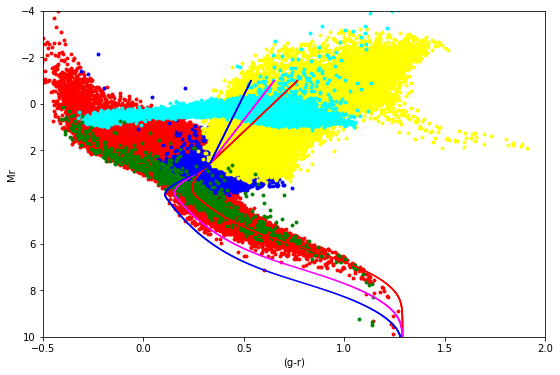

In [106]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_xlim(-0.5,2)
ax.set_ylim(10,-4.0) 
ax.set_xlabel('(g-r)')
ax.set_ylabel('Mr')

ax.scatter(T1['gr'], T1['Mr'], s=8.3, c='red')     
ax.scatter(T2['gr'], T2['Mr'], s=8.3, c='blue')     
ax.scatter(T3['gr'], T3['Mr'], s=8.3, c='yellow')     
ax.scatter(T456['gr'], T456['Mr'], s=8.3, c='cyan')     
ax.scatter(T0['gr'], T0['Mr'], s=8.3, c='green')     

ax.scatter(SDSSlocus0['gr']-0.1, SDSSlocus0['Mr'], s=0.3, ls='--', c='red')
ax.scatter(SDSSlocus1['gr']-0.1, SDSSlocus1['Mr'], s=0.3, ls='--', c='magenta')
ax.scatter(SDSSlocus2['gr']-0.1, SDSSlocus2['Mr'], s=0.3, ls='--', c='blue')

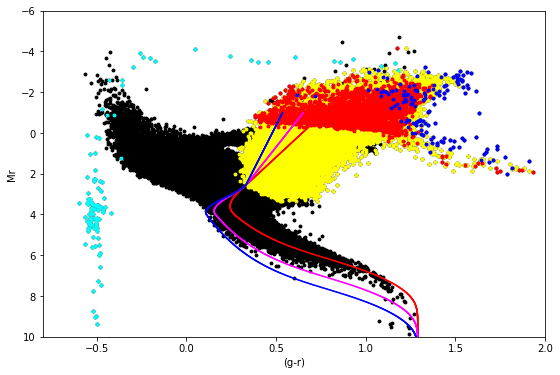

In [107]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_xlim(-0.8,2)
ax.set_ylim(10,-6.0) 
ax.set_xlabel('(g-r)')
ax.set_ylabel('Mr')

ax.scatter(df['gr'], df['Mr'], s=8.3, c='black')    
ax.scatter(T3['gr'], T3['Mr'], s=8.3, c='yellow')     
ax.scatter(T7['gr'], T7['Mr'], s=8.3, c='red')     
ax.scatter(T8['gr'], T8['Mr'], s=8.3, c='blue')     
ax.scatter(T9['gr'], T9['Mr'], s=8.3, c='cyan')      

ax.scatter(SDSSlocus0['gr']-0.1, SDSSlocus0['Mr'], s=0.3, ls='--', c='red')
ax.scatter(SDSSlocus1['gr']-0.1, SDSSlocus1['Mr'], s=0.3, ls='--', c='magenta')
ax.scatter(SDSSlocus2['gr']-0.1, SDSSlocus2['Mr'], s=0.3, ls='--', c='blue')

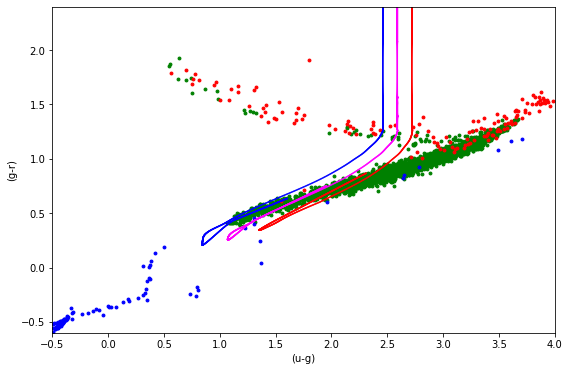

In [108]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_xlim(-0.5,4)
ax.set_ylim(-0.6,2.4) 
ax.set_xlabel('(u-g)')
ax.set_ylabel('(g-r)')

#ax.scatter(T1['ug'], T1['gr'], s=8.3, c='red')     
#ax.scatter(T2['ug'], T2['gr'], s=8.3, c='blue')     
#ax.scatter(T3['ug'], T3['gr'], s=8.3, c='yellow')     
#ax.scatter(T456['ug'], T456['gr'], s=8.3, c='cyan')     
#ax.scatter(T0['ug'], T0['gr'], s=8.3, c='green')     

ax.scatter(T7['ug'], T7['gr'], s=8.3, c='green')     
ax.scatter(T8['ug'], T8['gr'], s=8.3, c='red')     
ax.scatter(T9['ug'], T9['gr'], s=8.3, c='blue')     

ax.scatter(SDSSlocus0['ug']+0.06, SDSSlocus0['gr'], s=0.3, ls='--', c='red')
ax.scatter(SDSSlocus1['ug']+0.06, SDSSlocus1['gr'], s=0.3, ls='--', c='magenta')
ax.scatter(SDSSlocus2['ug']+0.06, SDSSlocus2['gr'], s=0.3, ls='--', c='blue')

### split by g-r and plot apparent mag vs. distance modulus

In [109]:
grMin =  0.2
grMax =  0.5
T0s = T0[(T0['gr']>grMin)&(T0['gr']<grMax)]
T1s = T1[(T1['gr']>grMin)&(T1['gr']<grMax)]
T2s = T2[(T2['gr']>grMin)&(T2['gr']<grMax)]
T3s = T3[(T3['gr']>grMin)&(T3['gr']<grMax)]
T4s = T456[(T456['gr']>grMin)&(T456['gr']<grMax)]
T7s = T7[(T7['gr']>grMin)&(T7['gr']<grMax)]
T8s = T8[(T8['gr']>grMin)&(T8['gr']<grMax)]
T9s = T9[(T9['gr']>grMin)&(T9['gr']<grMax)]
print(len(T0s), len(T1s), len(T2s), len(T3s), len(T4s), len(T7s), len(T8s), len(T9s))
#label   Evolutionary phase, PMS=0, MS=1, SGB=2, RGB=3, CHeB=4,5,6,
#                   EAGB=7, TPAGB=8, PAGB+WD=9

557 36753 5818 4708 5837 99 0 4


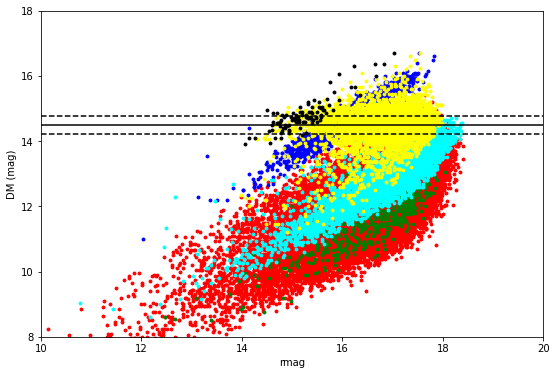

In [123]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_xlim(10,20)
ax.set_ylim(8,18.0) 
ax.set_xlabel('rmag')
ax.set_ylabel('DM (mag)')
ax.plot([10, 20], [14.5, 14.5], c='black', ls='-')
ax.plot([10, 20], [14.22, 14.22], c='black', ls='--')
ax.plot([10, 20], [14.77, 14.77], c='black', ls='--')

ax.scatter(T1s['rmag'], T1s['DM'], s=8.3, c='red')   
ax.scatter(T4s['rmag'], T4s['DM'], s=8.3, c='blue')   
ax.scatter(T0s['rmag'], T0s['DM'], s=8.3, c='green')   
ax.scatter(T2s['rmag'], T2s['DM'], s=8.3, c='cyan')  
ax.scatter(T3s['rmag'], T3s['DM'], s=8.3, c='yellow')  
ax.scatter(T7s['rmag'], T7s['DM'], s=8.3, c='black')  
ax.scatter(T8s['rmag'], T8s['DM'], s=8.3, c='red')  


In [124]:
goodDM = goodu[(goodu['DM']>10)&(goodu['DM']<16)]
print(len(goodu), len(goodDM))

279163 275033


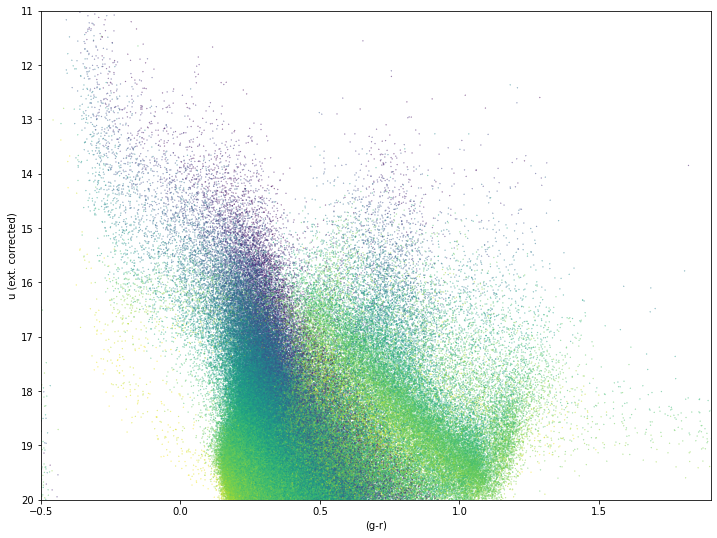

In [113]:
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.set_xlim(-0.5,1.9)
ax.set_ylim(20,11)  

ax.set_xlabel('(g-r)')
ax.set_ylabel('u (ext. corrected)')
ax.scatter(goodDM['gr'], goodDM['u'], s=0.05, c=goodDM['mu0']) 

#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

In [114]:
len(goodDM)

320083

In [115]:
!pip install astroML

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [116]:
from astroML.stats import binned_statistic_2d

In [117]:
N, xedges, yedges = binned_statistic_2d(goodDM['gr'], goodDM['u'], goodDM['mu0'], 'count', bins=200)

In [118]:
mu0mean, xedges, yedges = binned_statistic_2d(goodDM['gr'], goodDM['u'], goodDM['mu0'], 'mean', bins=200)

/data0/sw/anaconda3/lib/python3.8/site-packages/astroML/stats/_binned_statistic.py:321: RuntimeWarning: invalid value encountered in true_divide
  result[a] /= flatcount


<ipython-input-119-8a24eefc011b>:16: RuntimeWarning: divide by zero encountered in log10
  plt.contour(np.log10(N.T), levels, colors='k', linewidths=1,


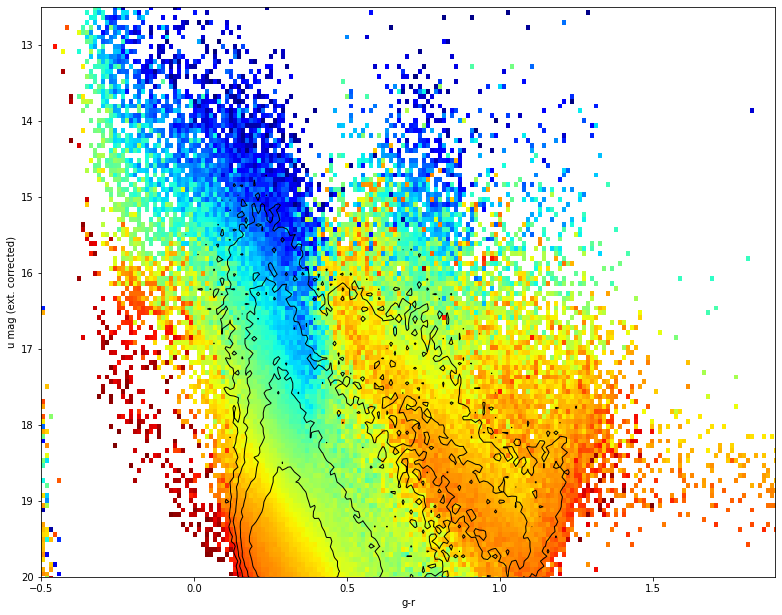

In [119]:
# Create figure and subplots
cmap_multicolor = plt.cm.jet
fig = plt.figure(figsize=(12, 9))
fig.subplots_adjust(wspace=0.25, left=0.1, right=0.95,
                    bottom=0.07, top=0.95)
plt.imshow(mu0mean.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap=cmap_multicolor)
plt.xlim(-0.5,1.9)
plt.ylim(20,12.5)

plt.xlabel('g-r')
plt.ylabel('u mag (ext. corrected)')

levels = np.linspace(0, np.log10(N.max()), 7)[2:]
plt.contour(np.log10(N.T), levels, colors='k', linewidths=1,
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.show()

In [120]:
N, xedges, yedges = binned_statistic_2d(goodDM['gr'], goodDM['g'], goodDM['mu0'], 'count', bins=200)
mu0mean, xedges, yedges = binned_statistic_2d(goodDM['gr'], goodDM['g'], goodDM['mu0'], 'mean', bins=200)

<ipython-input-121-8bc813ad1834>:16: RuntimeWarning: divide by zero encountered in log10
  plt.contour(np.log10(N.T), levels, colors='k', linewidths=1,


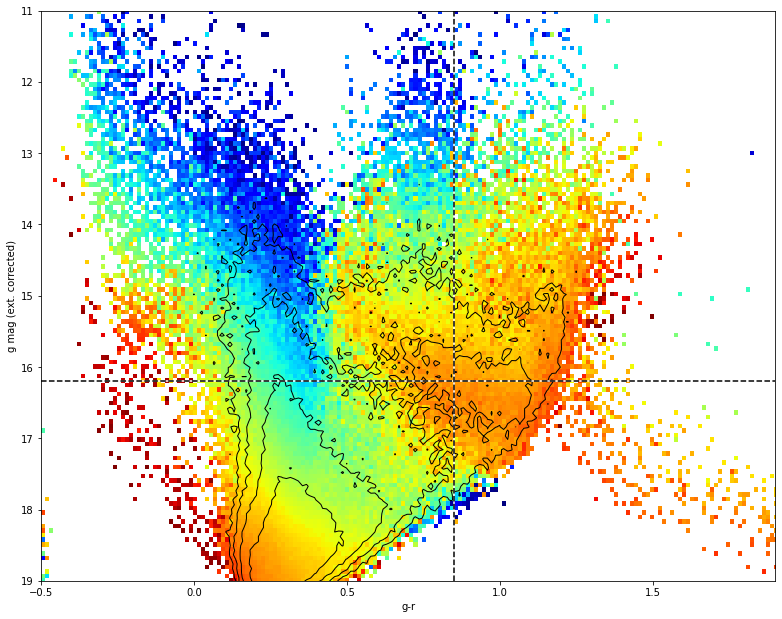

In [121]:
# Create figure and subplots
cmap_multicolor = plt.cm.jet
fig = plt.figure(figsize=(12, 9))
fig.subplots_adjust(wspace=0.25, left=0.1, right=0.95,
                    bottom=0.07, top=0.95)
plt.imshow(mu0mean.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap=cmap_multicolor)
plt.xlim(-0.5,1.9)
plt.ylim(19,11.0)

plt.xlabel('g-r')
plt.ylabel('g mag (ext. corrected)')

levels = np.linspace(0, np.log10(N.max()), 7)[2:]
plt.contour(np.log10(N.T), levels, colors='k', linewidths=1,
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

#cb = plt.colorbar(ticks=np.arange(10, 16, 2.0), format=r'$%.1f$', orientation='horizontal')
#cb.set_label('mean DM (mag)')
#plt.clim(10, 16)
plt.clim(14.22, 14.77)

plt.plot([-0.5,1.9], [16.2, 16.2], ls='-', c='white')
plt.plot([-0.5,1.9], [16.2, 16.2], ls='--', c='black')
plt.plot([0.85, 0.85], [11, 19], ls='-', c='white')
plt.plot([0.85, 0.85], [11, 19], ls='--', c='black')

plt.show()